In [2]:
import pickle
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import matplotlib.pyplot as plt


from scipy.special import softmax

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes_idx=np.arange(0,16)
    classes_idx = classes_idx[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Predicted labels',
           xlabel='True labels')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig

# Averaging fusion

Reading and cleaning operations

In [4]:
vision_preds_val = pickle.load( open( "../multimodal_net/final_outs_vis.pkl", "rb" ) )
audio_preds_val = pickle.load( open( "../multimodal_net/audio_predictions_val.pkl", "rb" ) )
audio_df_val = pd.DataFrame.from_dict(audio_preds_val, orient='index')
val_df = pd.read_csv("../multimodal_net/datasets/letsdance_splits/val.csv", header=None, sep='\t', names=['true', 'index', 'duration']).set_index('index')
classes_to_idx = pickle.load( open( "../multimodal_net/classes_to_idx.pkl", "rb" ) )
vision_df_val = pd.DataFrame.from_dict(vision_preds_val, orient='index').reset_index()
vision_df_val = vision_df_val.set_index('index')

In [5]:
idxes_to_classes = {val:key for (key, val) in classes_to_idx.items()}

Temporal visual averaging for each video

In [6]:
vision_df_val = pd.DataFrame(np.nanmean(vision_df_val.values.reshape(len(val_df), -1, len(classes_to_idx)), axis=1), index=vision_df_val.index)


Apply softmax on audio and visual models' outputs

In [7]:
audio_df_val_preds = audio_df_val.apply(softmax, axis=1)
vision_df_val_preds = vision_df_val.apply(softmax, axis=1)

Averaging

In [8]:
joint_df = (audio_df_val_preds+vision_df_val_preds)/2
joint_df['average_final'] = joint_df.idxmax(axis=1)

Create joint data frame to see the results side by side

In [9]:
vision_df_val['vision_final'] = vision_df_val.idxmax(axis=1)
audio_df_val['audio_final']=audio_df_val.idxmax(axis=1)
final_df = val_df.join(audio_df_val['audio_final']).drop(columns=['duration'])
final_df = final_df.join(vision_df_val['vision_final'])
final_df = final_df.join(joint_df['average_final'])

In [10]:

final_df['audio_final']=final_df['audio_final'].replace(idxes_to_classes)
final_df['vision_final']=final_df['vision_final'].replace(idxes_to_classes)
final_df['average_final']=final_df['average_final'].replace(idxes_to_classes)



Show all the missclassified examples 

In [11]:
final_df[final_df['true']!=final_df['average_final']]

,true,audio_final,vision_final,average_final
index,,,,
uKE-UnXbnL0_036,rumba,cha,cha,cha
Npe8Vv_YH3Q_020,swing,swing,pasodoble,pasodoble
nQxihx9WU_k_002,ballet,latin,ballet,latin
Pk1RfQvobxE_100,cha,cha,rumba,rumba
SzWNayeS-K8_009,tango,tango,foxtrot,foxtrot
D1ZYhVpdXbQ_227,tap,tap,pasodoble,pasodoble
dtU8mCSp2RE_302,samba,quickstep,rumba,quickstep
HknJUs3gPuE_804,jive,tap,pasodoble,tap
Rl88sW_rtv0_115,tap,break,rumba,break


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
pd.DataFrame({'Accuracy': accuracy_score(final_df['true'], final_df['average_final']),
'Precision': precision_score(final_df['true'], final_df['average_final'], average='macro'),
              "Recall": recall_score(final_df['true'], final_df['average_final'], average='macro')}, index=[0])

,Accuracy,Precision,Recall
0,0.741007,0.754315,0.744874


# SVM fusion

Reading traning examples and preparation

In [13]:
vision_preds = pickle.load( open( "../multimodal_net/final_outs_train_vis.pkl", "rb" ) )
audio_preds = pickle.load( open( "../multimodal_net/audio_predictions_train.pkl", "rb" ) )
audio_df = pd.DataFrame.from_dict(audio_preds, orient='index')
train_df = pd.read_csv("../multimodal_net/datasets/letsdance_splits/train.csv", header=None, sep='\t')
#                     )
classes_to_idx = pickle.load( open( "../multimodal_net/classes_to_idx.pkl", "rb" ) )
vision_preds_val = pickle.load( open( "../multimodal_net/final_outs_vis.pkl", "rb" ) )
audio_preds_val = pickle.load( open( "../multimodal_net/audio_predictions_val.pkl", "rb" ) )
audio_df_val = pd.DataFrame.from_dict(audio_preds_val, orient='index')
vision_df_val = pd.DataFrame.from_dict(vision_preds_val, orient='index').reset_index()
vision_df_val = vision_df_val.set_index('index')

vision_df_val = pd.DataFrame(np.nanmean(vision_df_val.values.reshape(139, -1, 16), axis=1), index=vision_df_val.index)
audio_df_val_preds = audio_df_val.apply(softmax, axis=1)
vision_df_val_preds = vision_df_val.apply(softmax, axis=1)

In [14]:
train_df = train_df.set_index(1)

In [17]:
vision_df = pd.DataFrame.from_dict(vision_preds, orient='index').reset_index()
# vision_df.columns = ['filename', 'vision_dec']
vision_df = vision_df.set_index('index')

vision_df = pd.DataFrame(np.nanmean(vision_df.values.reshape(len(train_df), -1, len(classes_to_idx)), axis=1), index=vision_df.index)


Apply softmax

In [18]:
audio_df = audio_df.apply(softmax, axis=1)
vision_df = vision_df.apply(softmax, axis=1)

Concatenate both representations

In [19]:
df = pd.concat([audio_df, vision_df], axis=1)
df_val = pd.concat([audio_df_val_preds, vision_df_val_preds], axis=1)

/home/monika/git/jersey_number_recognition/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
/home/monika/git/jersey_number_recognition/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [20]:
y_train=train_df[0].replace(classes_to_idx)
y_train=y_train.reindex(df.index)

Find best parameters with Randomised Grid Search

In [26]:
from scipy import stats
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
clf = svm.SVC()
tuned_parameters = {'kernel': ['rbf', 'linear'], 'gamma': stats.uniform(1e-4,10), 'C': stats.uniform(0.01,10)}


grid_search = RandomizedSearchCV(clf, tuned_parameters, scoring='accuracy',
                           cv=10, return_train_score=True, n_jobs=20, n_iter=500)
grid_search.fit(df, y_train)


/home/monika/git/jersey_number_recognition/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=500, n_jobs=20,
          param_distributions={'kernel': ['rbf', 'linear'], 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1089dd7e10>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1089dd79e8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

Best model details

In [27]:
best_model = grid_search.best_estimator_
best_model

SVC(C=1.9874912757208596, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=9.708583341776034,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Get predictions for validation set

In [28]:
df_val = df_val.reindex(final_df.index)
final_df['svm_final'] = best_model.predict(df_val)
final_df['svm_final']=final_df['svm_final'].replace(idxes_to_classes)

Add SVM decision and compare all results on validation set

In [29]:
final_df[final_df['average_final']!=final_df['svm_final']]

,true,audio_final,vision_final,average_final,svm_final
index,,,,,
_YnwZjcA3X0_024,quickstep,latin,quickstep,quickstep,latin
Npe8Vv_YH3Q_020,swing,swing,pasodoble,pasodoble,swing
Pk1RfQvobxE_100,cha,cha,rumba,rumba,cha
SzWNayeS-K8_009,tango,tango,foxtrot,foxtrot,tango
HknJUs3gPuE_804,jive,tap,pasodoble,tap,pasodoble
xz2V44lQlqA_035,tap,pasodoble,tap,tap,pasodoble
AV8y1PNmrTg_110,cha,pasodoble,samba,samba,pasodoble
TGvyix_esxo_411,pasodoble,pasodoble,rumba,rumba,pasodoble
3zCT36UnEcA_220,tango,tango,foxtrot,foxtrot,tango


Final metrics

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
pd.DataFrame({'Accuracy': accuracy_score(final_df['true'], final_df['svm_final']),
'Precision': precision_score(final_df['true'], final_df['svm_final'], average='macro'),
              "Recall": recall_score(final_df['true'], final_df['svm_final'], average='macro')}, index=[0])

,Accuracy,Precision,Recall
0,0.769784,0.780073,0.786176


Confusion matrix, without normalization


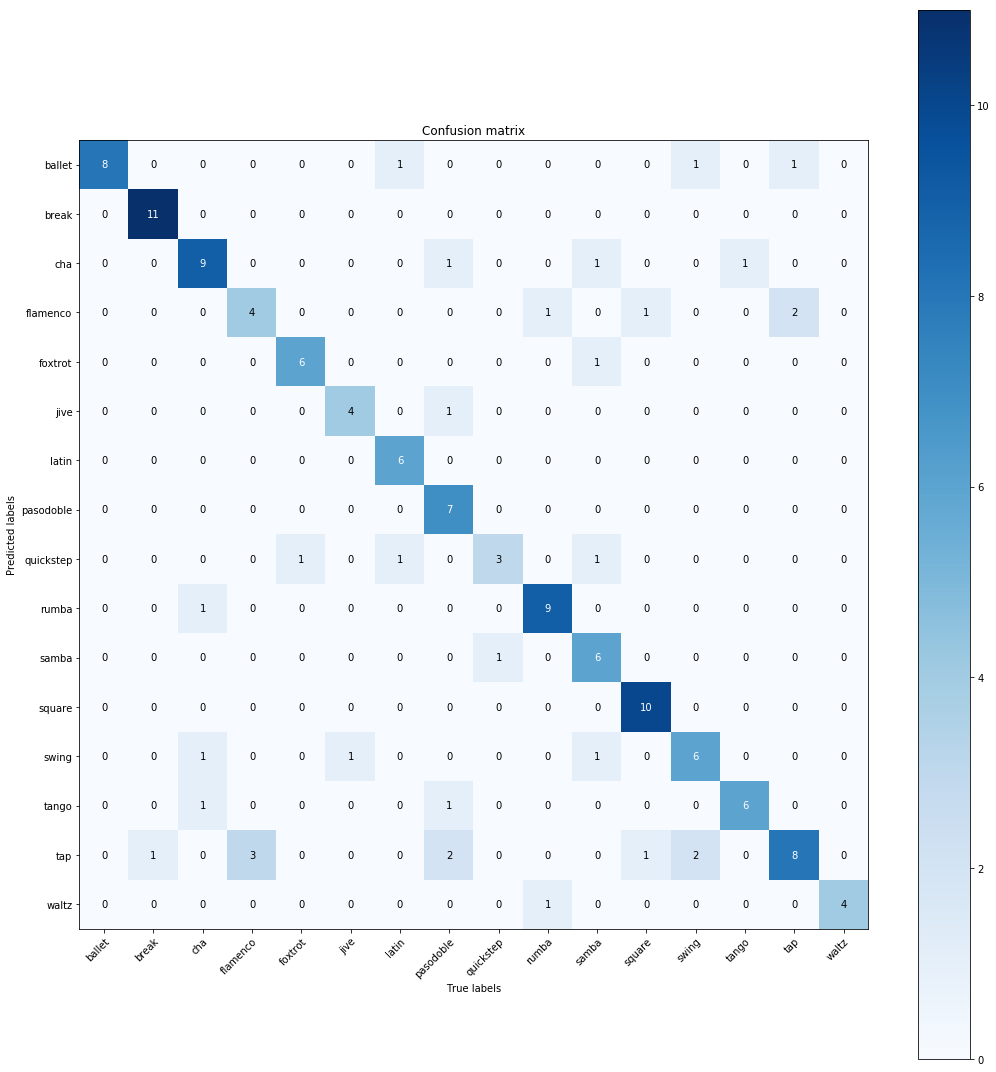

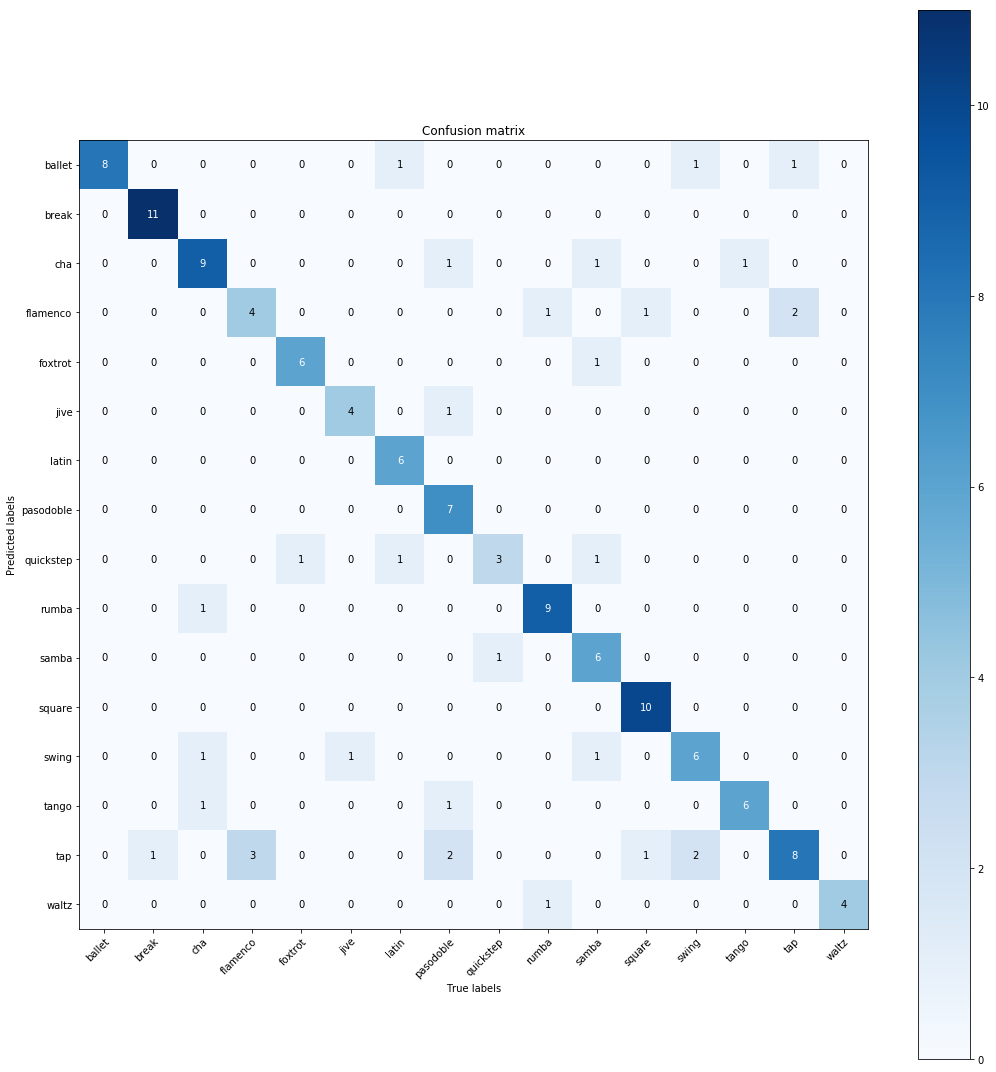

In [31]:
from sklearn.utils.multiclass import unique_labels

plot_confusion_matrix(final_df['true'].replace(classes_to_idx), final_df['svm_final'].replace(classes_to_idx),  sorted(classes_to_idx.keys()))